# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [6]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [16]:
from MADDPG import Actor, Critic, ReplayBuffer, OUNoise
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
%matplotlib inline

In [8]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-2              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 2e-4        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

ADD_NOISE = True
SEED = 0

In [9]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
DEVICE

device(type='cuda', index=0)

In [13]:
out_path = './'

In [14]:
shared_memory = ReplayBuffer(DEVICE, action_size, BUFFER_SIZE, BATCH_SIZE, SEED)
noise = OUNoise(action_size, SEED)


Agent_0 = 0
Agent_1 = 1

# We have one critic and two actors environment 

Agent0_Actor = Actor(DEVICE, Agent_0, state_size, action_size, SEED, 
                     shared_memory, noise, LR_ACTOR, WEIGHT_DECAY,out_path)
Agent1_Actor = Actor(DEVICE, Agent_1, state_size, action_size, SEED, 
                     shared_memory, noise, LR_ACTOR, WEIGHT_DECAY, out_path)

Shared_Critic = Critic(DEVICE, state_size, action_size, SEED, 
                       GAMMA, TAU, LR_CRITIC, WEIGHT_DECAY, out_path)

In [18]:
scores = []
scores_window = deque(maxlen=100)
n_episodes = 6000
scores_avg = []
for i_episode in range(n_episodes):
    env_info = env.reset(train_mode=True)[brain_name]            
    states = env_info.vector_observations                        
    Agent0_Actor.reset()                                             
    Agent1_Actor.reset()
                                              
    score = np.zeros(num_agents)
    
        
    while True:
        agent0_action = Agent0_Actor.act(states[Agent_0], ADD_NOISE)
        agent1_action = Agent1_Actor.act(states[Agent_1], ADD_NOISE)
        actions = np.concatenate( (agent0_action, agent1_action) )
        
        env_info = env.step(actions)[brain_name]                              
        next_states = env_info.vector_observations                      
        rewards = env_info.rewards                                  
        dones = env_info.local_done                                

        Agent0_Actor.step(states[Agent_0], agent0_action, rewards[Agent_0], next_states[Agent_0], dones[Agent_0])
        Agent1_Actor.step(states[Agent_1], agent1_action, rewards[Agent_1], next_states[Agent_1], dones[Agent_1])
            
        Shared_Critic.step(Agent0_Actor, shared_memory)
        Shared_Critic.step(Agent1_Actor, shared_memory)

        score += rewards                                         
        
        states = next_states                                          
                                                        
        if np.any( dones ):      
            break                                        

    Agent0_Actor.checkpoint()
    Agent1_Actor.checkpoint()
    Shared_Critic.checkpoint()

    scores.append(score)
    scores_window.append(score)
    scores_avg.append(np.mean(scores_window))
        
    print('\rEpisode: \t{} \tScore: \t{:.2f} \tAverage Score: \t{:.2f}'.format(
        i_episode, np.mean(score), np.mean(scores_window)), end="")  
    if i_episode % 100 ==0:
        print('\rEpisode: \t{} \tScore: \t{:.2f} \tAverage Score: \t{:.2f}'.format(
        i_episode, np.mean(score), np.mean(scores_window)))
        
    if np.mean(scores_window) >= 0.5:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        break    
 
    


# train the agent


Episode: 	0 	Score: 	-0.00 	Average Score: 	-0.00
Episode: 	100 	Score: 	-0.00 	Average Score: 	-0.00
Episode: 	200 	Score: 	-0.00 	Average Score: 	-0.00
Episode: 	300 	Score: 	-0.00 	Average Score: 	-0.00
Episode: 	400 	Score: 	-0.00 	Average Score: 	0.000
Episode: 	500 	Score: 	0.05 	Average Score: 	0.066
Episode: 	600 	Score: 	0.50 	Average Score: 	0.300
Episode: 	700 	Score: 	0.15 	Average Score: 	0.398
Episode: 	800 	Score: 	2.10 	Average Score: 	0.442
Episode: 	854 	Score: 	2.50 	Average Score: 	0.504
Environment solved in 854 episodes!	Average Score: 0.50


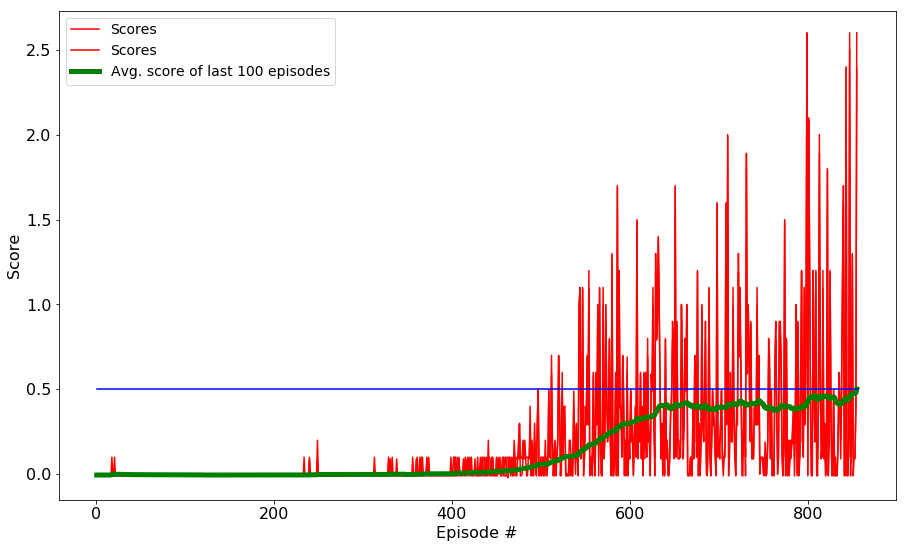

In [20]:
import matplotlib


matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16


figsize = 15,9
figure, ax = plt.subplots(figsize=figsize)
plt.plot(np.arange(1, len(scores)+1), scores, 'r', label='Scores')
plt.plot(np.arange(1, len(scores)+1), scores_avg,'g',\
         linewidth=5,label='Avg. score of last 100 episodes')
plt.plot([1,len(scores)+1], [.5,.5], 'b')
plt.ylabel('Score',  fontsize=16)
plt.xlabel('Episode #',  fontsize=16)
plt.savefig('MADDPG_tennis.png')
ax.legend(fontsize=14)
plt.show()

In [23]:
# test the trained agents
for episode in range(4):
    env_info = env.reset(train_mode=False)[brain_name]           # reset the environment
    states = env_info.vector_observations                        # get initial states
    score = np.zeros(num_agents)
    
    while True:
        action_0 = Agent0_Actor.act(states[Agent_0], add_noise=False)
        action_1 = Agent1_Actor.act(states[Agent_1], add_noise=False)
        actions = np.concatenate((action_0, action_1))
        
        env_info = env.step( actions )[brain_name]               # send the action to the environment                            
        next_states = env_info.vector_observations               # get the next state        
        rewards = env_info.rewards                               # get the reward        
        dones = env_info.local_done                              # see if episode has finished        
        
        score += rewards

        states = next_states

        if np.any(dones):                              
            break

    print('Episode: \t{} \tScore: \t{:.2f}'.format(episode+1, np.max(score)))



Episode: 	1 	Score: 	2.60
Episode: 	2 	Score: 	2.60
Episode: 	3 	Score: 	2.70
Episode: 	4 	Score: 	2.60
